<a href="https://colab.research.google.com/github/rpizarrog/machine_learning_r_python_casos_de_estudio/blob/main/notebook_Python/LDA_datos_de_pacientes_Enfermos_Sanos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivo

Implementar modelo LDA con datos relacionados con personas con enfermedad o sanos




# Generar los datos


In [1]:
import numpy as np
import pandas as pd

# Semilla para reproducibilidad
np.random.seed(2025)

# Número de registros (ajústalo a 3000 o 50000)
N = 4500

# Variables simuladas
edad = np.random.normal(50, 12, N).clip(18, 90)                # edad en años
imc = np.random.normal(28, 5, N).clip(16, 50)                  # índice de masa corporal
presion_sys = np.random.normal(125, 15, N).clip(90, 220)       # presión arterial sistólica
glucosa = np.random.normal(110, 25, N).clip(70, 400)           # glucosa en sangre
colesterol = np.random.normal(190, 35, N).clip(100, 350)       # colesterol total
ejercicio_h = np.random.normal(2.5, 1.5, N).clip(0, 14)        # horas de ejercicio/semana
fumador = np.random.binomial(1, 0.25, N)                       # fumador: 0=no, 1=sí
sexo = np.random.binomial(1, 0.5, N)                           # sexo: 0=femenino, 1=masculino

# Variable latente de riesgo (modelo lineal simple con ruido)
z = (0.04*edad + 0.1*imc + 0.03*presion_sys + 0.05*glucosa +
     0.02*colesterol - 0.3*ejercicio_h + 0.5*fumador + 0.1*sexo +
     np.random.normal(0, 5, N))

# Probabilidad de enfermedad (ej. diabetes tipo 2)
p = 1 / (1 + np.exp(-(z - 50) / 10))

# Clase categórica
enfermedad = np.where(np.random.rand(N) < p, "Enfermo", "Sano")

# Construir DataFrame
datos = pd.DataFrame({
    "edad": edad.astype(int),
    "imc": imc.round(1),
    "presion_sys": presion_sys.round(1),
    "glucosa": glucosa.round(1),
    "colesterol": colesterol.round(1),
    "ejercicio_h": ejercicio_h.round(1),
    "fumador": fumador,
    "sexo": np.where(sexo==0, "F", "M"),
    "clase": enfermedad
})

print(datos.head(10))
print("\nDistribución de la variable clase:")
print(datos["clase"].value_counts())

datos.to_csv("datos_personas_enfermos_sanos_LDA.csv")


   edad   imc  presion_sys  glucosa  colesterol  ejercicio_h  fumador sexo  \
0    48  29.4         94.4    108.6       150.7          2.3        0    F   
1    58  31.8        121.2    109.0       189.8          3.8        0    M   
2    32  31.7        104.1    128.1       144.8          1.2        0    M   
3    42  26.5        131.7    128.3       137.8          4.6        1    F   
4    48  24.1        104.5    112.3       105.6          1.3        1    F   
5    75  24.9        124.8    118.3       204.6          4.5        0    M   
6    66  38.6        117.7     81.6       212.0          1.7        0    M   
7    47  30.1        110.8     76.1       222.6          1.4        1    F   
8    59  30.6        129.6     94.4       209.9          2.6        0    M   
9    52  32.4        130.2    104.4       223.2          0.0        0    M   

     clase  
0     Sano  
1  Enfermo  
2     Sano  
3     Sano  
4     Sano  
5     Sano  
6     Sano  
7     Sano  
8     Sano  
9     Sano 

# Cargar librerías


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA # PCA

# Para graficos
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar funciones del caso


In [3]:

# Función para mostrar primero y ultimos registros
def f_primeros_ultimos_datos(datos, n=10):

    if not isinstance(datos, pd.DataFrame):
        raise ValueError("El argumento 'datos' debe ser un DataFrame de pandas.")
    if n < 1:
        raise ValueError("El valor de 'n' debe ser mayor o igual a 1.")

    primeros = datos.head(n)
    ultimos = datos.tail(n)

    # print(f"\nPrimeros {n} registros ---")
    # print(primeros)

    # print(f"\nÚltimos {n} registros ---")
    # print(ultimos)

    return primeros, ultimos

# Función que implementa el modelo LDA
# Recibe un conjunto de datos y
# devuelve matriz de dos dimensiones
# Solo utiliza las variables numéricas
# En el proceso la función identifica la variable clase,
# selecciona el resto de los atributos que necesariamente deben ser numéricos
# Escala los datos y construye el modelo LDA para cosntruir la primer dimensoin D1,
# luego complementa con el modelo PCA para
# construir la segunda dimensión D2
def f_construir_LDA(datos):
    """
    Construye un nuevo DataFrame con dimensiones D1 (LDA) y D2 (PC1 ortogonalizado a w).
    Usa SOLO variables numéricas; 'clase' es la variable objetivo categórica.
    """
    if "clase" not in datos.columns:
        raise ValueError("El DataFrame debe contener la columna 'clase'.")

    # Separar objetivo
    y = datos["clase"].values

    # Tomar SOLO columnas numéricas (descarta 'sexo' u otras categóricas)
    X_num = datos.drop(columns=["clase"], errors="ignore").select_dtypes(include=[np.number])

    if X_num.shape[1] == 0:
        raise ValueError("No hay columnas numéricas para entrenar LDA.")

    # Escalar
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X_num.values)

    # LDA → D1 (para 2 clases, 1 dimensión)
    lda = LinearDiscriminantAnalysis(n_components=1)
    D1 = lda.fit_transform(Xs, y).ravel()  # (N,)

    # Eje ortogonal D2 desde PCA y Gram–Schmidt contra w
    w = lda.coef_[0]
    w_norm = w / np.linalg.norm(w)

    pca = PCA(n_components=1)
    pc1 = pca.fit(Xs).components_[0]

    orto = pc1 - np.dot(pc1, w_norm) * w_norm
    D2_dir = orto / np.linalg.norm(orto)

    D2 = (Xs @ D2_dir).ravel()

    # Armar salida
    dimensiones = pd.DataFrame({
        "id": datos.index + 1,
        "clase": y,
        "D1": np.round(D1, 4),
        "D2": np.round(D2, 4),
    })
    return dimensiones

# Función para visualizar dispersión de datos redimensionados
# Recibe datos redimensionados
def f_dispersion_dimensiones_LDA(datos_dim):
    plt.figure(figsize=(8,6))
    colores = {'Sano': 'green', 'Enfermo': 'red'}

    for clase in datos_dim['clase'].unique():
        subset = datos_dim[datos_dim['clase'] == clase]
        plt.scatter(
            subset['D1'], subset['D2'],
            c=colores[clase], label=clase, alpha=0.6, edgecolors='k'
        )

    plt.xlabel("Dimensión 1 (LDA)")
    plt.ylabel("Dimensión 2 (PCA ortogonal)")
    plt.title("Proyección en dos dimensiones (LDA + eje ortogonal)")
    plt.legend()
    plt.grid(True)
    plt.show()


# Función que devuelve el valor de la razón de Fisher
def fisher_ratio(datos):
    # Solo numéricas y variable objetivo
    X = datos.drop(columns=["clase"]).select_dtypes(include=[np.number]).values
    y = datos["clase"].values
    clases = np.unique(y)

    # Escalar
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    # Medias global y por clase
    mu_global = Xs.mean(axis=0)
    medias = {c: Xs[y == c].mean(axis=0) for c in clases}

    # SW (dentro de clases)
    SW = np.zeros((Xs.shape[1], Xs.shape[1]))
    for c in clases:
        Xc = Xs[y == c]
        Mc = Xc - medias[c]
        SW += Mc.T @ Mc

    # SB (entre clases)
    SB = np.zeros((Xs.shape[1], Xs.shape[1]))
    for c in clases:
        nk = np.sum(y == c)
        diff = (medias[c] - mu_global).reshape(-1, 1)
        SB += nk * (diff @ diff.T)

    # w de LDA
    lda = LinearDiscriminantAnalysis(n_components=1)
    lda.fit(Xs, y)
    w = lda.coef_[0].reshape(-1, 1)

    # Calcular razón de Fisher
    numerador = float(w.T @ SB @ w)
    denominador = float(w.T @ SW @ w)
    J = numerador / denominador

    return {
        "numerador": numerador,
        "denominador": denominador,
        "fisher_ratio": J
    }


# Cargar funciones para tablas


In [4]:
# --- INSTALACIÓN ---
!pip -q install python-docx pandas numpy

import pandas as pd
import numpy as np
from docx import Document
from docx.shared import Inches, Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.oxml.shared import OxmlElement, qn

# ====== UTILIDADES PARA DOCX ======
def _set_tbl_borders(table, show=False):
    """Bordes finos opcionales en header y perímetro; show=True para ver líneas."""
    if not show:
        # sin bordes (limpio)
        tbl = table._tbl
        borders = OxmlElement('w:tblBorders')
        for side in ('top','left','bottom','right','insideH','insideV'):
            e = OxmlElement(f'w:{side}')
            e.set(qn('w:val'), 'nil')
            borders.append(e)
        tbl.tblPr.append(borders)

def _apply_narrow_layout(doc):
    # Carta vertical, márgenes estándar
    for s in doc.sections:
        s.page_height = Inches(11)
        s.page_width  = Inches(8.5)
        s.top_margin    = Inches(1)
        s.bottom_margin = Inches(1)
        s.left_margin   = Inches(1)
        s.right_margin  = Inches(1)

def _wrap_header_text(name: str):
    # Forzar wraps suaves en encabezados largos:
    # - reemplaza '_' por salto de línea
    # - inserta salto antes de mayúsculas internas (CamelCase simple) para ayudar a envolver
    import re
    name = name.replace('_', '\n')
    name = re.sub(r'(?<!^)(?=[A-Z][a-z])', '\n', name)  # Ej: totalVentas -> total\nVentas
    return name

def _compute_equal_widths(num_cols, total_width_in=6.5):
    # Reparte ancho total de la tabla en columnas iguales
    w = total_width_in / max(1, num_cols)
    return [Inches(w)] * num_cols

def df_to_docx_narrow_table(df: pd.DataFrame, doc: Document, title: str,
                            total_width_in: float = 6.5,
                            font_size_pt: float = 9.5,
                            show_borders: bool = False):
    """
    Inserta una tabla 'angosta' en el Document:
      - una sola pieza (todas las columnas)
      - ancho fijo: table.autofit=False y anchos de columna iguales
      - tipografía compacta
      - encabezados con saltos de línea para evitar desbordes
    """
    # Título
    p = doc.add_paragraph(title)
    p.style = doc.styles['Heading 2']
    p.paragraph_format.space_after = Pt(6)

    # Conversión a str para evitar NaN
    safe = df.copy()
    for c in safe.columns:
        safe[c] = safe[c].astype(str)

    n_rows, n_cols = safe.shape
    table = doc.add_table(rows=0, cols=n_cols)
    _set_tbl_borders(table, show=show_borders)

    # Header
    hdr_cells = table.add_row().cells
    for j, col in enumerate(safe.columns):
        # Encabezado con posibles saltos de línea
        header_text = _wrap_header_text(str(col))
        # Escribimos con saltos reales en Word
        para = hdr_cells[j].paragraphs[0]
        for k, frag in enumerate(header_text.split('\n')):
            run = para.add_run(frag if k == 0 else ("\n" + frag))
            run.bold = True
            run.font.size = Pt(font_size_pt)
        para.alignment = WD_ALIGN_PARAGRAPH.CENTER

    # Filas
    for i in range(n_rows):
        row_cells = table.add_row().cells
        for j, col in enumerate(safe.columns):
            para = row_cells[j].paragraphs[0]
            run = para.add_run(str(safe.iloc[i, j]))
            run.font.size = Pt(font_size_pt)
            para.alignment = WD_ALIGN_PARAGRAPH.LEFT

    # Anchos fijos
    table.autofit = False
    col_widths = _compute_equal_widths(n_cols, total_width_in=total_width_in)
    for j, w in enumerate(col_widths):
        table.columns[j].width = w
        # Forzar ancho "preferido"
        for cell in table.columns[j].cells:
            cell.width = w

    # Espacio después de la tabla
    doc.add_paragraph("")

def export_docx_narrow(head10, tail10,
                       path_docx_both="tablas_datos_head_tail_word_narrow.docx",
                       path_docx_head="tablas_datos_head10_word_narrow.docx",
                       path_docx_tail="tablas_datos_tail10_word_narrow.docx",
                       total_width_in=6.5, font_size_pt=9.5, show_borders=False):
    # Documento con ambas tablas (una debajo de la otra)
    doc_both = Document()
    _apply_narrow_layout(doc_both)
    df_to_docx_narrow_table(head10, doc_both, "Vista previa (primeros 10 registros)",
                            total_width_in, font_size_pt, show_borders)
    df_to_docx_narrow_table(tail10, doc_both, "Vista previa (últimos 10 registros)",
                            total_width_in, font_size_pt, show_borders)
    doc_both.save(path_docx_both)

    # Documentos individuales
    doc_h = Document(); _apply_narrow_layout(doc_h)
    df_to_docx_narrow_table(head10, doc_h, "Vista previa (primeros 10 registros)",
                            total_width_in, font_size_pt, show_borders)
    doc_h.save(path_docx_head)

    doc_t = Document(); _apply_narrow_layout(doc_t)
    df_to_docx_narrow_table(tail10, doc_t, "Vista previa (últimos 10 registros)",
                            total_width_in, font_size_pt, show_borders)
    doc_t.save(path_docx_tail)

# ====== HTML EN UNA SOLA TABLA ANGOSTA ======
def df_to_html_narrow_single_table(df: pd.DataFrame, title: str = "", table_width_px: int = 700):
    safe = df.copy()
    for c in safe.columns:
        safe[c] = safe[c].astype(str)

    # CSS: tabla angosta, layout fijo, wrap agresivo
    css = f"""
    <style>
      body {{ font-family: Arial, Helvetica, sans-serif; font-size: 12pt; line-height: 1.35; margin: 0; padding: 0.2in; }}
      h2 {{ font-size: 14pt; margin: 0 0 0.15in 0; }}
      table.narrow {{
        width: {table_width_px}px;
        table-layout: fixed;
        border-collapse: collapse;
        border: 1px solid #ddd;
        font-size: 10pt;
      }}
      table.narrow th, table.narrow td {{
        border: 1px solid #ddd;
        padding: 6px 8px;
        vertical-align: top;
        word-wrap: break-word;
        overflow-wrap: anywhere;
        white-space: normal;
      }}
      table.narrow th {{
        background: #f4f4f4;
        text-align: center;
        font-weight: bold;
      }}
    </style>
    """

    # Encabezados con "soft wrap": reemplaza '_' por <br>
    def wrap_header(col):
        import re
        col = str(col).replace('_', '<br>')
        col = re.sub(r'(?<!^)(?=[A-Z][a-z])', '<br>', col)
        return col

    html = [f"<!DOCTYPE html><html><head><meta charset='utf-8'>{css}</head><body>"]
    if title:
        html.append(f"<h2>{title}</h2>")
    html.append("<table class='narrow'><thead><tr>")
    for col in safe.columns:
        html.append(f"<th>{wrap_header(col)}</th>")
    html.append("</tr></thead><tbody>")

    for _, row in safe.iterrows():
        html.append("<tr>")
        for col in safe.columns:
            html.append(f"<td>{row[col]}</td>")
        html.append("</tr>")
    html.append("</tbody></table></body></html>")
    return "".join(html)

def export_html_narrow(
    head10, tail10,
    path_html_headtail="tablas_datos_ventas_head10tail10_epub_narrow.html",
    path_html_head="tablas_datos_head10_epub_narrow.html",
    path_html_tail="tablas_datos_tail10_epub_narrow.html",
    table_width_px=700,
    modo="dos_tablas"  # "dos_tablas" (2 tablas en una página) o "una_tabla" (head+tail concatenados)
):
    """
    Requiere que exista df_to_html_narrow_single_table(df, title="", table_width_px=700)
    y que 'head10' y 'tail10' sean DataFrames.
    """

    # HTML individuales
    h_head = df_to_html_narrow_single_table(head10, "Vista previa (primeros 10 registros)", table_width_px)
    h_tail = df_to_html_narrow_single_table(tail10, "Vista previa (últimos 10 registros)", table_width_px)

    # Guardar individuales
    with open(path_html_head, "w", encoding="utf-8") as f:
        f.write(h_head)
    with open(path_html_tail, "w", encoding="utf-8") as f:
        f.write(h_tail)

    # Combinar en un solo HTML
    if modo == "dos_tablas":
        # Reutiliza el <head> (con CSS) del primero y mete ambos <body> uno tras otro
        def body_only(html):
            s = html.lower().find("<body>")
            e = html.lower().find("</body>")
            return html[s+6:e].strip() if s != -1 and e != -1 else html

        h_start = h_head.lower().find("<head>")
        h_end   = h_head.lower().find("</head>")
        head_block = h_head[h_start:h_end+7] if h_start != -1 and h_end != -1 else "<head><meta charset='utf-8'></head>"

        combined = [
            "<!DOCTYPE html><html>",
            head_block,
            "<body>",
            # botones de navegación internos (opcional)
            "<p><a href='#head10'>Ir a head(10)</a> | <a href='#tail10'>Ir a tail(10)</a></p>",
            "<div id='head10'>", body_only(h_head), "</div>",
            "<hr style='margin:0.2in 0;border:0;border-top:1px solid #ddd;'>",
            "<div id='tail10'>", body_only(h_tail), "</div>",
            "</body></html>"
        ]
        html_headtail = "".join(combined)

    elif modo == "una_tabla":
        import pandas as pd
        head_tag = head10.copy()
        tail_tag = tail10.copy()
        head_tag.insert(0, "_sección_", "head(10)")
        tail_tag.insert(0, "_sección_", "tail(10)")
        df_union = pd.concat([head_tag, tail_tag], ignore_index=True)
        html_headtail = df_to_html_narrow_single_table(
            df_union, "Vista previa (head(10)+tail(10) en una sola tabla)", table_width_px
        )
    else:
        raise ValueError("modo debe ser 'dos_tablas' o 'una_tabla'")

    with open(path_html_headtail, "w", encoding="utf-8") as f:
        f.write(html_headtail)

    # print("Listo. Archivos generados:")
    # print(" -", path_html_headtail)
    # print(" -", path_html_head)
    # print(" -", path_html_tail)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 6.2 MB/s eta 0:00:00


# Cargar datos


In [5]:
# url = "https://raw.githubusercontent.com/rpizarrog/machine_learning_r_python_casos_de_estudio/refs/heads/main/datos/datos_personas_enfermos_sanos_LDA.csv"

url = "https://raw.githubusercontent.com/rpizarrog/machine_learning_r_python_casos_de_estudio/refs/heads/main/datos/datos_salud_separable_LDA.csv"
datos = pd.read_csv(url)

# Análisis preeliminar de los datos

## Estadísticos

In [6]:
np.round(datos.describe(), 2)

,edad,imc,glucosa,hba1c,presion_sys,colesterol_total,hdl,ldl,trigliceridos,ejercicio_h,pasos_diarios,fumador
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,50.16,28.27,120.43,6.49,129.28,196.82,47.92,127.68,173.08,2.46,7185.64,0.25
std,11.41,4.50,33.59,1.37,15.76,36.32,11.34,33.40,64.76,1.77,2715.17,0.43
min,19.00,13.19,61.11,3.99,87.60,90.90,20.11,40.01,10.57,-2.00,476.00,0.00
25%,42.00,25.11,93.64,5.34,117.54,171.21,39.66,103.59,124.41,1.00,5174.50,0.00
50%,50.00,28.12,109.22,5.87,127.56,193.95,47.28,125.75,162.24,2.00,7162.50,0.00
75%,58.00,31.43,148.53,7.69,139.54,220.30,55.52,149.22,217.51,4.00,9157.25,0.00
max,87.00,43.59,229.84,11.05,184.98,315.91,81.93,246.22,381.10,9.00,14548.00,1.00


## Estructura de los datos


In [ ]:
datos.info()

## Primeros y últimos registros


In [25]:
head10, tail10 = f_primeros_ultimos_datos(datos, n=10)
head10 = np.round(head10, 2)
head10

,edad,imc,glucosa,hba1c,presion_sys,colesterol_total,hdl,ldl,trigliceridos,ejercicio_h,pasos_diarios,fumador,clase
0,31,28.27,67.52,5.60,117.24,190.87,55.32,141.04,113.16,0,13040,0,Sano
1,47,22.14,75.77,5.06,128.95,163.14,60.32,108.67,180.21,3,11324,0,Sano
2,52,26.01,98.26,5.27,117.73,186.69,46.85,130.35,137.39,3,10673,0,Sano
3,65,33.85,148.80,9.67,148.63,209.96,48.74,163.58,231.77,1,7604,1,Enfermo
4,52,32.92,143.77,6.83,126.70,195.50,52.08,118.10,205.78,1,2583,0,Enfermo
5,57,32.40,98.42,5.21,121.02,196.97,66.01,119.46,139.58,3,8295,0,Sano
6,54,36.49,165.03,8.65,145.83,206.22,35.91,190.01,193.19,0,4319,0,Enfermo
7,46,24.11,69.77,5.34,112.12,139.45,39.10,98.77,105.43,1,11379,0,Sano
8,53,25.69,91.39,5.08,115.86,162.75,50.43,66.79,124.46,1,6701,1,Sano
9,58,21.51,85.06,4.87,114.69,178.37,56.21,115.83,106.44,5,8395,1,Sano


In [28]:
tail10=np.round(tail10, 2)
tail10

,edad,imc,glucosa,hba1c,presion_sys,colesterol_total,hdl,ldl,trigliceridos,ejercicio_h,pasos_diarios,fumador,clase
990,35,29.36,107.79,5.86,126.89,163.13,66.09,144.80,108.78,6,5058,0,Sano
991,64,32.86,147.62,7.80,154.22,217.09,42.35,141.26,184.28,2,4616,0,Enfermo
992,40,21.65,78.24,5.10,129.62,165.88,61.97,75.13,158.11,3,4275,0,Sano
993,46,21.89,85.52,5.60,127.55,198.52,68.82,76.26,158.75,2,9150,0,Sano
994,53,32.39,101.95,5.16,87.60,176.65,57.05,110.84,144.65,4,8623,1,Sano
995,55,26.88,86.34,5.89,110.56,179.06,65.10,132.09,151.32,4,12696,0,Sano
996,44,21.04,105.71,5.78,117.44,222.43,57.51,146.93,148.61,5,8304,0,Sano
997,54,32.39,159.04,7.85,143.70,229.77,44.35,144.16,218.24,3,7147,1,Enfermo
998,39,24.73,98.51,5.64,104.41,183.66,50.05,97.70,61.90,4,11356,0,Sano
999,73,23.63,166.34,8.25,160.73,218.31,46.36,197.98,90.34,0,8972,0,Enfermo


# Generar tablas HTML para EPUB datos originales


In [27]:
# Llamar tablas para Word
export_docx_narrow(
    head10, tail10,
    path_docx_both="tablas_datos_salud_dosclases_head10tail10_word_narrow.docx",
    path_docx_head="tablas_datos_salud_dosclases_head10_word_narrow.docx",
    path_docx_tail="tablas_datos_salud_dosclases_tail10_word_narrow.docx",
    total_width_in=6.5,     # ancho total de tabla (ajusta a 6.0 si quieres aún más angosta)
    font_size_pt=9.5,       # tipografía compacta
    show_borders=True       # True = bordes finos visibles; False = look editorial sin líneas
)

export_html_narrow(
    head10, tail10,
    path_html_headtail="tablas_datos_salud_dosclases_head10tail10_word_narrow.html",
    path_html_head="tablas_datos_salud_dosclases_head10_epub_narrow.html",
    path_html_tail="tablas_datos_salud_dosclases_tail10_epub_narrow.html",
    table_width_px=680,
    modo="dos_tablas"  # o "una_tabla"
)

print("Listo. Archivos generados:")
print("tablas_datos_salud_dosclases_head10tail10_epub_narrow.docx")
print("tablas_datos_salud_dosclases_head10_word_narrow.docx")
print("tablas_datos_salud_dosclases_tail10_word_narrow.docx")
print("tablas_datos_salud_dosclases_head10tail10_epub_narrow.html")
print("tablas_datos_salud_dosclases_head10_epub_narrow.html")
print("tablas_datos_salud_dosclases_tail10_epub_narrow.html")


Listo. Archivos generados:
tablas_datos_salud_dosclases_head10tail10_epub_narrow.docx
tablas_datos_salud_dosclases_head10_word_narrow.docx
tablas_datos_salud_dosclases_tail10_word_narrow.docx
tablas_datos_salud_dosclases_head10tail10_epub_narrow.html
tablas_datos_salud_dosclases_head10_epub_narrow.html
tablas_datos_salud_dosclases_tail10_epub_narrow.html


## Construir modelo LDA


In [ ]:
datos_dos_dimensiones = f_construir_LDA(datos)
f_primeros_ultimos_datos(datos_dos_dimensiones, n=10)

(   id    clase      D1      D2
 0   1     Sano  3.4566 -0.8795
 1   2     Sano  4.0306 -1.2881
 2   3     Sano  2.8670 -0.5269
 3   4  Enfermo -5.6088  0.8098
 4   5  Enfermo -1.9188  0.7590
 5   6     Sano  2.7140 -0.1499
 6   7  Enfermo -5.6588  1.7433
 7   8     Sano  4.0086 -1.1390
 8   9     Sano  3.0467 -0.2598
 9  10     Sano  4.4016 -0.8398,
        id    clase      D1      D2
 990   991     Sano  2.5177 -1.2370
 991   992  Enfermo -3.6263  1.2800
 992   993     Sano  3.6029 -1.0009
 993   994     Sano  3.2877 -1.4461
 994   995     Sano  3.4339 -0.6733
 995   996     Sano  3.5141 -1.6181
 996   997     Sano  2.5285 -1.0865
 997   998  Enfermo -3.5650  0.7670
 998   999     Sano  4.1090 -2.1607
 999  1000  Enfermo -3.7184  0.7394)

## Visualizar datos redimensionados


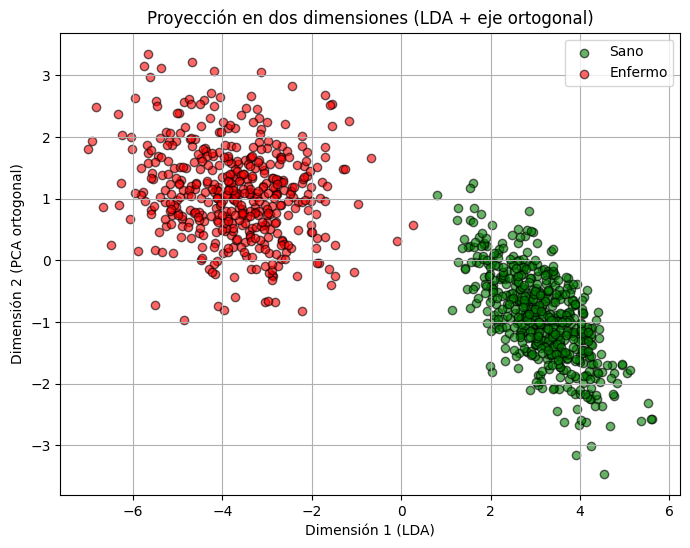

In [ ]:
# Visualizar
f_dispersion_dimensiones_LDA(datos_dos_dimensiones)

# Modelo LDA para datos de pacientes con tres valores en la clase

# Cargar librerías y funciones

In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

# Función que construye un modelo LDA con mas de dos valroes en la clase
# Devuelve una matriz de 2D para tres valores
# No necesita modelo PCA
def f_construir_LDA_de_mas_valores_en_clase(datos, devolver_modelos=False):
    if "clase" not in datos.columns:
        raise ValueError("El DataFrame debe contener la columna 'clase'.")

    # Objetivo
    y = datos["clase"].values

    # Solo numéricas como X
    X_num = datos.drop(columns=["clase"], errors="ignore").select_dtypes(include=[np.number])
    if X_num.shape[1] == 0:
        raise ValueError("No hay columnas numéricas para entrenar LDA.")

    if not np.isfinite(X_num.values).all():
        raise ValueError("Hay valores no finitos en las columnas numéricas. Limpia/imputa antes.")

    # Escalado
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X_num.values)

    # LDA: máximo de componentes = min(p, K-1)
    clases = np.unique(y)
    K = len(clases)
    if K < 2:
        raise ValueError("Se requieren al menos 2 clases para LDA.")

    n_comp = min(Xs.shape[1], K - 1, 2)  # hasta 2 para graficar
    lda = LinearDiscriminantAnalysis(n_components=n_comp)
    Z = lda.fit_transform(Xs, y)  # shape: (N, n_comp)

    # D1 siempre
    D1 = Z[:, 0]

    # D2:
    if n_comp >= 2:
        # Tenemos LDA real para el segundo eje
        D2 = Z[:, 1]
        w_vec = None  # no necesitamos fabricar eje ortogonal
    else:
        # K=2 → fabricar D2 con PC1 ortogonal a w (solo visual)
        w = lda.coef_[0]
        w_norm = w / np.linalg.norm(w)
        pc1 = PCA(n_components=1).fit(Xs).components_[0]
        orto = pc1 - np.dot(pc1, w_norm) * w_norm
        D2_dir = orto / np.linalg.norm(orto)
        D2 = (Xs @ D2_dir).ravel()
        w_vec = w_norm

    # Salida
    dimensiones = pd.DataFrame({
        "id": datos.index + 1,
        "clase": y,
        "D1": np.round(D1, 4),
        "D2": np.round(D2, 4)
    })

    if devolver_modelos:
        return dimensiones, lda, scaler, w_vec
    return dimensiones


# Cargar datos

In [30]:
url = "https://raw.githubusercontent.com/rpizarrog/machine_learning_r_python_casos_de_estudio/refs/heads/main/datos/datos_salud_3clases.csv"
datos_tres_clases = pd.read_csv(url)



## Primeros registros


In [31]:
head10, tail10 = f_primeros_ultimos_datos(datos_tres_clases, n=10)
head10


,edad,imc,glucosa,hba1c,presion_sys,colesterol_total,hdl,ldl,trigliceridos,ejercicio_h,pasos_diarios,fumador,clase
0,67,31.2,96,7.0,143,257,39,192,195,2.0,4456,0,Enfermo
1,39,21.0,90,5.5,111,187,69,113,114,4.2,8873,0,Sano
2,77,32.2,188,8.9,156,254,39,196,195,2.2,6137,0,Enfermo
3,65,28.4,165,9.4,163,232,33,182,135,0.9,3479,0,Enfermo
4,65,32.6,128,7.4,136,218,46,143,232,1.7,7709,0,Enfermo
5,45,21.8,60,4.9,116,198,47,101,129,2.4,9043,0,Sano
6,37,24.3,104,4.9,106,149,63,117,77,3.9,11382,0,Sano
7,58,39.1,140,7.0,146,234,44,75,275,1.3,3411,1,Enfermo
8,54,25.6,154,6.4,132,158,54,128,153,2.3,7695,0,Riesgo
9,24,26.7,80,5.4,109,169,63,103,87,5.3,11534,0,Sano


## Ultimos registros

In [32]:
tail10

,edad,imc,glucosa,hba1c,presion_sys,colesterol_total,hdl,ldl,trigliceridos,ejercicio_h,pasos_diarios,fumador,clase
990,68,32.2,125,7.5,135,193,54,252,239,0.8,4643,1,Enfermo
991,31,21.6,106,4.9,129,147,52,105,75,5.1,9826,1,Sano
992,36,20.9,76,5.2,118,160,52,134,113,1.4,6557,0,Sano
993,33,24.2,108,5.5,100,209,56,100,73,7.0,13050,0,Sano
994,71,29.5,164,7.9,149,231,36,66,202,1.2,5697,0,Enfermo
995,36,19.2,88,5.1,122,239,59,97,100,1.3,10477,0,Sano
996,64,25.5,111,6.6,133,188,59,123,153,2.7,7695,0,Riesgo
997,48,28.4,107,6.0,133,158,45,84,239,0.0,10167,1,Riesgo
998,41,27.0,83,4.9,114,141,47,100,109,7.2,9998,0,Sano
999,29,23.7,93,5.2,120,186,75,106,108,1.9,12083,0,Sano


# Tablas Para EPUB

In [33]:
export_docx_narrow(
    head10, tail10,
    path_docx_both="tablas_datos_salud_tresclases_head10tail10_word_narrow.docx",
    path_docx_head="tablas_datos_salud_tresclases_head10_word_narrow.docx",
    path_docx_tail="tablas_datos_salud_tresclases_tail10_word_narrow.docx",
    total_width_in=6.5,     # ancho total de tabla (ajusta a 6.0 si quieres aún más angosta)
    font_size_pt=9.5,       # tipografía compacta
    show_borders=True       # True = bordes finos visibles; False = look editorial sin líneas
)

export_html_narrow(
    head10, tail10,
    path_html_headtail="tablas_datos_salud_tresclases_head10tail10_epub_narrow.html",
    path_html_head="tablas_datos_salud_tresclases_head10_epub_narrow.html",
    path_html_tail="tablas_datos_salud_tresclases_tail10_epub_narrow.html",
    table_width_px=680,
    modo="dos_tablas"  # o "una_tabla"
)

print("Listo. Archivos generados:")
print("tablas_datos_salud_tresclases_head10tail10_epub_narrow.docx")
print("tablas_datos_salud_tresclases_head10_word_narrow.docx")
print("tablas_datos_salud_tresclases_tail10_word_narrow.docx")
print("tablas_datos_salud_tresclases_head10tail10_epub_narrow.html")
print("tablas_datos_salud_tresclases_head10_epub_narrow.html")
print("tablas_datos_salud_tresclases_tail10_epub_narrow.html")

Listo. Archivos generados:
tablas_datos_salud_tresclases_head10tail10_epub_narrow.docx
tablas_datos_salud_tresclases_head10_word_narrow.docx
tablas_datos_salud_tresclases_tail10_word_narrow.docx
tablas_datos_salud_tresclases_head10tail10_epub_narrow.html
tablas_datos_salud_tresclases_head10_epub_narrow.html
tablas_datos_salud_tresclases_tail10_epub_narrow.html
